In [5]:
import pandas as pd
from tqdm.auto import tqdm
from radon.metrics import mi_visit
from radon.complexity import cc_visit
from radon.raw import analyze
import numpy as np


In [6]:


df = pd.read_csv('commit_analysis_rectified.csv')
# df = df[df['Filename'].str.endswith('.py')].dropna(subset=['Source Code (before)', 'Source Code (current)'])

In [7]:
df.head()

,Hash,Message,Filename,Source Code (before),Source Code (current),Diff,LLM Inference (fix type),Rectified Message
0,4e5d290b925a1fb9d74628ff8c64f9ed8ef86d60,#1 general fixes,api_data.py,#!/usr/bin/env python\n\nimport json\nimport s...,#!/usr/bin/env python\n\nimport json\nimport s...,"@@ -2,34 +2,31 @@\n \n import json\n import sy...",add missing comments,add missing comments
1,892a28ced8a782e74d276f962d41b9cc037bff90,#1 Minor fixes,api_data.py,#!/usr/bin/env python\n\nimport json\nimport s...,#!/usr/bin/env python\n\nimport json\nimport s...,"@@ -10,23 +10,30 @@ def output_cve_id(type=Non...",add missing comments,add missing comments
2,09413f9691905afc0ca3a886c7480cff3e9d6bd8,#2 Fixes unit tests,test_api_data.py,#\n# Copyright (c) 2017 nexB Inc. and others. ...,#\n# Copyright (c) 2017 nexB Inc. and others. ...,"@@ -73,11 +73,12 @@ def test_extract_fields():...",add test for,add test for
3,ee2a03d7fdb6c1ad4f14f56c23da084b3a21ed10,Fix expected value for the test_debian_extract...,test_scrapers.py,#\n# Copyright (c) 2017 nexB Inc. and others. ...,#\n# Copyright (c) 2017 nexB Inc. and others. ...,"@@ -67,26 +67,30 @@ def test_debian_extract_da...",add tests for debian-test,add tests for debian-test
4,0334beb45e3370ea11e4bc0f8abc53409a09a872,Fixed pycodestyle error and re-worded variable...,data_dump.py,#\n# Copyright (c) 2017 nexB Inc. and others. ...,#\n# Copyright (c) 2017 nexB Inc. and others. ...,"@@ -28,11 +28,13 @@ from vulncode_app.models i...",add more comments,add more comments


Total number of unique commits: 327
Total number of files modified: 1336

Average number of files modified per commit: 4.085626911314985
Distribution of fix types:
LLM Inference (fix type)
add missing comments                               63
add missing tags                                   30
add missing import                                 26
add missing docstrings                             24
add test for                                       22
                                                   ..
add missing doc for repository url                  1
add migration migration for vulnerabilities         1
add migration migration for vulnerability tests     1
add test for the new debian test                    1
add tests for the latest vulnerabilities            1
Name: count, Length: 885, dtype: int64


Top 5 most frequently modified file extensions:
extension
py      882
json    267
html     86
rst      28
yml      17
Name: count, dtype: int64


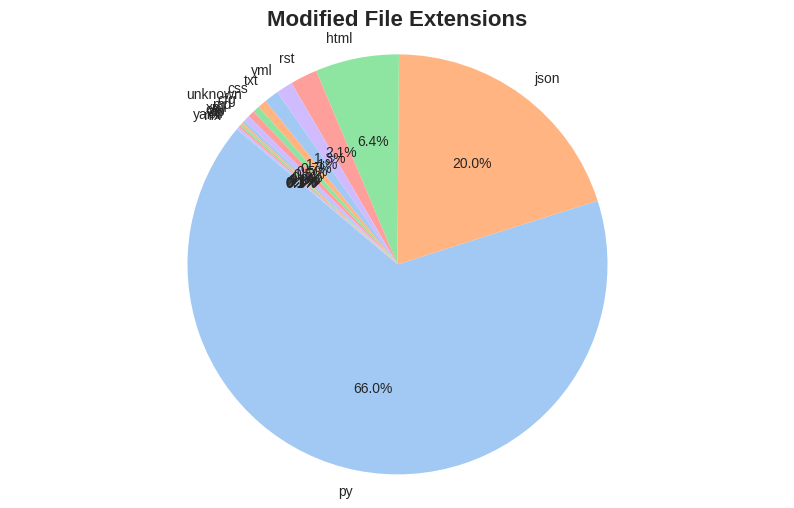

In [9]:
# Total number of unique commits and total files
total_commits = df['Hash'].nunique()
total_files = len(df)
print(f"Total number of unique commits: {total_commits}")
print(f"Total number of files modified: {total_files}\n")

print("Average number of files modified per commit:", total_files / total_commits)

# Distribution of fix types
fix_type_distribution = df['LLM Inference (fix type)'].value_counts()
print("Distribution of fix types:")
print(fix_type_distribution)
print("\n")

# Most frequently modified file extensions
df['extension'] = df['Filename'].apply(lambda x: x.split('.')[-1] if '.' in x else 'unknown')
extension_distribution = df['extension'].value_counts().head(5)
print("Top 5 most frequently modified file extensions:")
print(extension_distribution)

# plot a pie chart for all file extensions
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
plt.style.use('seaborn-v0_8-whitegrid')
colors = sns.color_palette('pastel')[0:5]
plt.pie(df['extension'].value_counts(), labels=df['extension'].value_counts().index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Modified File Extensions', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

/tmp/ipykernel_7328/654347284.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='LLM Inference (fix type)', order=df['LLM Inference (fix type)'].value_counts().index[:10], palette='viridis')


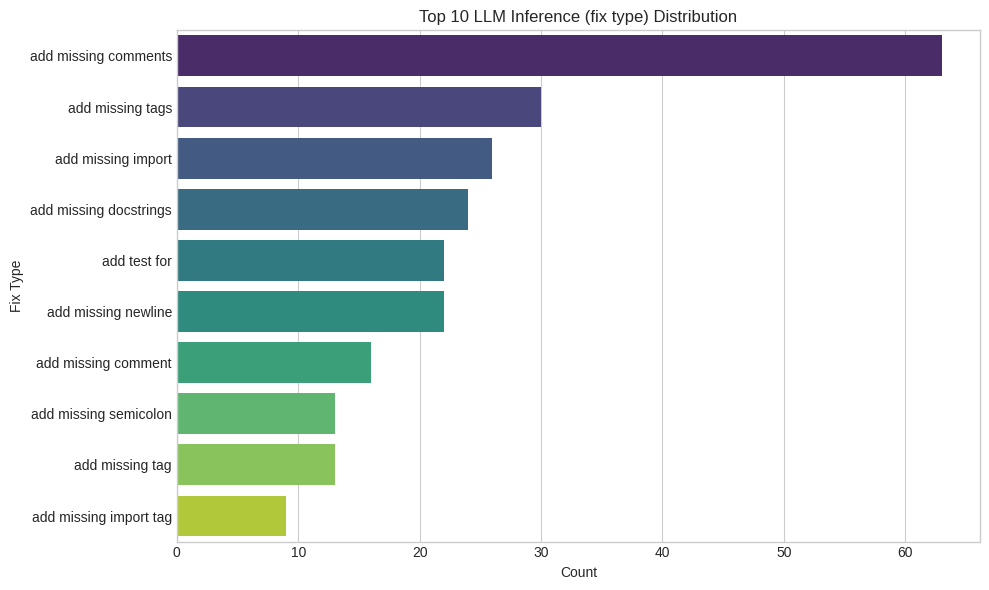

In [10]:
#plot for LLM Inference (fix type) and its value counts only take top 10 values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.countplot(data=df, y='LLM Inference (fix type)', order=df['LLM Inference (fix type)'].value_counts().index[:10], palette='viridis')
plt.title('Top 10 LLM Inference (fix type) Distribution')
plt.xlabel('Count')
plt.ylabel('Fix Type')
plt.tight_layout()
plt.show()

In [6]:
def analyze_code_metrics(code):
    try:
        if not isinstance(code, str) or not code.strip():
            return None, None, None
        mi_score = mi_visit(code, True)
        cc_results = cc_visit(code)
        cc_score = sum(c.complexity for c in cc_results)
        loc = analyze(code).loc
        return mi_score, cc_score, loc
    except Exception:
        return None, None, None

# Apply the function to the 'before' and 'current' source code columns
tqdm.pandas(desc="Analyzing 'before' code")
df[['MI_Before', 'CC_Before', 'LOC_Before']] = df['Source Code (before)'].progress_apply(lambda c: pd.Series(analyze_code_metrics(c)))

tqdm.pandas(desc="Analyzing 'current' code")
df[['MI_After', 'CC_After', 'LOC_After']] = df['Source Code (current)'].progress_apply(lambda c: pd.Series(analyze_code_metrics(c)))

# Calculate the change columns as required [cite: 90, 92, 94]
df['MI_Change'] = df['MI_After'] - df['MI_Before']
df['CC_Change'] = df['CC_After'] - df['CC_Before']
df['LOC_Change'] = df['LOC_After'] - df['LOC_Before']

print("\nStructural metrics (MI, CC, LOC) calculated and added to the DataFrame.")

Analyzing 'before' code:   1%|          | 6/763 [00:00<00:12, 59.07it/s]

Analyzing 'before' code:  67%|██████▋   | 514/763 [00:31<00:14, 17.65it/s]<unknown>:104: SyntaxWarning: invalid escape sequence '\['
<unknown>:104: SyntaxWarning: invalid escape sequence '\['
Analyzing 'before' code:  75%|███████▍  | 572/763 [00:35<00:09, 19.36it/s]<unknown>:110: SyntaxWarning: invalid escape sequence '\['
<unknown>:110: SyntaxWarning: invalid escape sequence '\['
Analyzing 'before' code:  80%|████████  | 613/763 [00:37<00:07, 19.67it/s]<unknown>:110: SyntaxWarning: invalid escape sequence '\['
<unknown>:110: SyntaxWarning: invalid escape sequence '\['
Analyzing 'current' code:  67%|██████▋   | 513/763 [00:24<00:16, 15.35it/s]<unknown>:110: SyntaxWarning: invalid escape sequence '\['
<unknown>:110: SyntaxWarning: invalid escape sequence '\['
Analyzing 'current' code:  75%|███████▍  | 572/763 [00:28<00:11, 17.15it/s]<unknown>:110: SyntaxWarning: invalid escape sequence '\['
<unknown>:110: SyntaxWarning: invalid escape sequence '\['
Analyzing 'current' code:  80%|███████


Structural metrics (MI, CC, LOC) calculated and added to the DataFrame.


In [ ]:
import torch
import sacrebleu
from transformers import RobertaTokenizer, RobertaModel

# --- Semantic Similarity with CodeBERT ---
print("\nSetting up CodeBERT model...")
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"CodeBERT is running on: {device}")

def get_semantic_similarity(code_pair):
    code1, code2 = code_pair
    try:
        tokens1 = tokenizer(code1, return_tensors='pt', truncation=True, max_length=512).to(device)
        tokens2 = tokenizer(code2, return_tensors='pt', truncation=True, max_length=512).to(device)
        with torch.no_grad():
            embedding1 = model(**tokens1).pooler_output
            embedding2 = model(**tokens2).pooler_output
        return torch.nn.functional.cosine_similarity(embedding1, embedding2).item()
    except Exception:
        return None


def get_bleu_score(code_pair):
    code_before, code_after = code_pair
    if not isinstance(code_before, str) or not isinstance(code_after, str):
        return None
    return sacrebleu.corpus_bleu([code_after], [[code_before]], tokenize='char').score / 100.0


# Apply these functions to the DataFrame
print("\n Calculating Semantic Similarity (CodeBERT)... this may take a while.")
tqdm.pandas(desc="Semantic Similarity")
df['Semantic_Similarity'] = df[['Source Code (before)', 'Source Code (current)']].progress_apply(get_semantic_similarity, axis=1)

print("\n Calculating Token Similarity (BLEU)...")
tqdm.pandas(desc="Token Similarity")
df['Token_Similarity'] = df[['Source Code (before)', 'Source Code (current)']].progress_apply(get_bleu_score, axis=1)

print("\nChange magnitude metrics calculated.")


Setting up CodeBERT model...
CodeBERT is running on: cpu

 Calculating Semantic Similarity (CodeBERT)... this may take a while.


Semantic Similarity: 100%|██████████| 763/763 [21:43<00:00,  1.71s/it]



 Calculating Token Similarity (BLEU)...


Token Similarity: 100%|██████████| 763/763 [00:26<00:00, 28.84it/s]


Change magnitude metrics calculated.


In [ ]:

SEMANTIC_THRESHOLD = 0.80 
TOKEN_THRESHOLD = 0.75 

print(f"\n Classifying fixes based on thresholds (Semantic: {SEMANTIC_THRESHOLD}, Token: {TOKEN_THRESHOLD})...")


df['Semantic_Class'] = np.where(df['Semantic_Similarity'] >= SEMANTIC_THRESHOLD, 'Minor', 'Major')
df['Token_Class'] = np.where(df['Token_Similarity'] >= TOKEN_THRESHOLD, 'Minor', 'Major')

df['Classes_Agree'] = np.where(df['Semantic_Class'] == df['Token_Class'], 'YES', 'NO')


df.to_csv('final_commit_analysis.csv', index=False)

print("\nAll tasks complete! The final dataset has been saved to 'final_commit_analysis.csv'")

# Display a sample of the final table structure [cite: 115, 117]
print("\nFinal Data Sample:")
print(df[[
    'MI_Change', 'CC_Change', 'LOC_Change', 'Semantic_Similarity',
    'Token_Similarity', 'Semantic_Class', 'Token_Class', 'Classes_Agree'
]].head())


 Classifying fixes based on thresholds (Semantic: 0.8, Token: 0.75)...

All tasks complete! The final dataset has been saved to 'final_commit_analysis.csv'

Final Data Sample:
   MI_Change  CC_Change  LOC_Change  Semantic_Similarity  Token_Similarity  \
0    2.57842        1.0        -3.0             0.987385          0.730958   
1   -8.19662        6.0         7.0             0.995658          0.832680   
2   -2.06861        0.0         1.0             1.000000          0.936685   
3        NaN        NaN         NaN             1.000000          0.963835   
4    0.00000        1.0         8.0             0.999880          0.957028   

  Semantic_Class Token_Class Classes_Agree  
0          Minor       Major            NO  
1          Minor       Minor           YES  
2          Minor       Minor           YES  
3          Minor       Minor           YES  
4          Minor       Minor           YES  


In [ ]:

tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")
bleu = BLEU()

def get_semantic_similarity(code1, code2):
    if not code1.strip() or not code2.strip():
        return 0.0
    try:
        # Tokenize and get embeddings
        tokens1 = tokenizer(code1, return_tensors="pt", truncation=True, max_length=512)
        tokens2 = tokenizer(code2, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            embedding1 = model(**tokens1).pooler_output
            embedding2 = model(**tokens2).pooler_output
        # Compute cosine similarity
        return cosine_similarity(embedding1, embedding2)[0][0]
    except Exception:
        return 0.0

def get_token_similarity(code1, code2):
    if not code1.strip() or not code2.strip():
        return 0.0

    score = bleu.sentence_score(hypothesis=code2, references=[code1])
    return score.score / 100.0 # Scale to 0-1 range


df['Semantic_Similarity'] = df.apply(lambda row: get_semantic_similarity(row['Source Code (before)'], row['Source Code (current)']), axis=1)
df['Token_Similarity'] = df.apply(lambda row: get_token_similarity(row['Source Code (before)'], row['Source Code (current)']), axis=1)

print("Change magnitude metrics calculated.")
print(df[['Semantic_Similarity', 'Token_Similarity']].head())

In [4]:
import pandas as pd

df = pd.read_csv('final_commit_analysis.csv')
df['Classes_Agree'].value_counts("NO")

Classes_Agree
YES    0.925295
NO     0.074705
Name: proportion, dtype: float64